In [1]:
import os
import arcpy
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

In [2]:
os.chdir("..") # return to the main directory
home_wd = os.getcwd()
home_wd

'c:\\Users\\milan\\OneDrive - MUNI\\VŠ\\PhD\\Zahraniční stáž\\Work\\HeiGIT_notebooks\\analysis\\ai-assisted-osm-mapping-stats'

In [3]:
state_dic = {
    0: "India",
    1: "Vietnam",
    2: "Tanzania",
    3: "Kenya",
    4: "Nigeria"
}

In [4]:
# user input definition

while True:
    try:
        user_data_spec = int(input("Which grid data do you want to split?\
                            Enter a number:\
                            0 for India,\
                            1 for Vietnam,\
                            2 for Tanzania,\
                            3 for Kenya,\
                            4 for Nigeria,\
                                :"
                                ))
    except ValueError:
        print("Please enter a number.")
        continue
    if user_data_spec not in range(len(state_dic)):
        print(f"Please enter one of these numbers: {state_dic.keys()}.")
        continue
    break

In [5]:
in_grid = os.path.join(home_wd, r"shp\origin_downloaded_layers\heigit_hexagrid.shp")
in_states = os.path.join(home_wd, r"shp\origin_downloaded_layers\ne_10m_admin_0_sovereignty.shp")
out_grid_geojson = os.path.join(home_wd, f"geojson-hexagrid-states\\{state_dic[user_data_spec]}", "")

temp_shp = os.path.join(home_wd,r"shp\temporary-shp", "")

In [6]:
out_grid_geojson

'c:\\Users\\milan\\OneDrive - MUNI\\VŠ\\PhD\\Zahraniční stáž\\Work\\HeiGIT_notebooks\\analysis\\ai-assisted-osm-mapping-stats\\geojson-hexagrid-states\\India\\'

In [7]:
# get the data types

field_info = arcpy.Describe(in_grid).fields

for field in field_info:
    print(f"{field.name}: {field.type}")

FID: OID
Shape: Geometry
fid_1: Double
id: Double
timestamp: String
value: Double
value_per_: Double
id_int: Integer


In [8]:
# Add a new field to store the copied values
# arcpy.management.AddField(in_grid, "id_int", "INTEGER")

In [9]:
# Copy the values from the original field to the new field
# arcpy.management.CalculateField(in_grid, "id_int", "!id!")

In [10]:
# arcpy.management.DeleteField(in_grid, "new_field")

### Local Selection – Selection of the grids from the layer with user's specified state

In [11]:
field = arcpy.AddFieldDelimiters(in_states, "NAME_EN")
selection = "{field} = '{val}'".format(field=field, val=state_dic[user_data_spec])
sel_state = arcpy.management.SelectLayerByAttribute(in_states, "NEW_SELECTION", 
                                        selection)

In [12]:
sel_state_grids = arcpy.management.SelectLayerByLocation(in_grid,
                                                        "INTERSECT",
                                                        sel_state ,
                                                        None,
                                                        "NEW_SELECTION")

In [13]:
count = 0
with arcpy.da.SearchCursor(sel_state_grids, ['id_int']) as cursor:
    for row in cursor:
        count+=1
count

23287

In [14]:
arcpy.conversion.FeatureClassToFeatureClass(sel_state_grids, temp_shp, state_dic[user_data_spec], )


<Result 'c:\\Users\\milan\\OneDrive - MUNI\\VŠ\\PhD\\Zahraniční stáž\\Work\\HeiGIT_notebooks\\analysis\\ai-assisted-osm-mapping-stats\\shp\\temporary-shp\\India.shp'>

In [15]:
print((f"{temp_shp}{state_dic[user_data_spec]}"))

c:\Users\milan\OneDrive - MUNI\VŠ\PhD\Zahraniční stáž\Work\HeiGIT_notebooks\analysis\ai-assisted-osm-mapping-stats\shp\temporary-shp\India


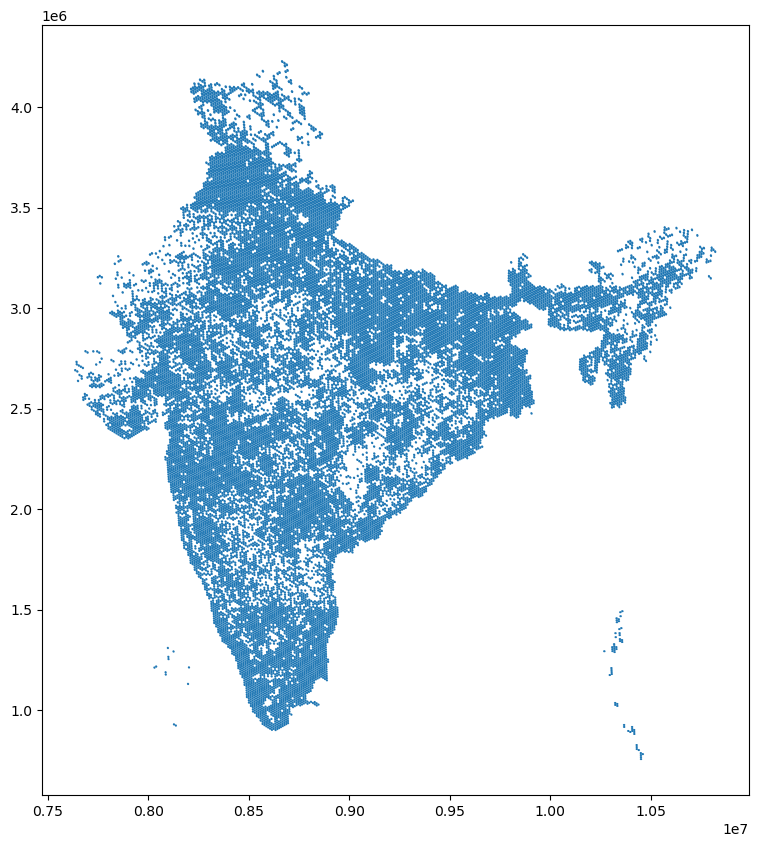

<Result 'true'>

In [16]:
# Verify the selection
data = gpd.read_file(f"{temp_shp}{state_dic[user_data_spec]}.shp")

# Plot the shapefile using GeoPandas
fig, ax = plt.subplots(figsize=(10, 10))
data.plot(ax=ax)
plt.show()

arcpy.management.Delete(f"{temp_shp}{state_dic[user_data_spec]}.shp")

In [17]:
with arcpy.da.SearchCursor(sel_state_grids, ["id_int", "SHAPE@"]) as cur:
    for row in cur:
        arcpy.conversion.FeaturesToJSON(row[1],
        f"{out_grid_geojson}{row[0]}_{state_dic[user_data_spec]}.geojson",
        geoJSON=True)

KeyboardInterrupt: 

### Global Selection – Selection of all desired states and grids from the layers

In [7]:
sel_state_lst = ['India', 'Vietnam', 'Tanzania', 'Kenya', 'Nigeria']

In [8]:
def buildWhereClauseFromList(table, field, valueList):
    """Takes a list of values and constructs a SQL WHERE
    clause to select those values within a given field and table."""

    # Add DBMS-specific field delimiters
    fieldDelimited = arcpy.AddFieldDelimiters(arcpy.Describe(table).path, field)

    # Determine field type
    fieldType = arcpy.ListFields(table, field)[0].type

    # Add single-quotes for string field values
    if str(fieldType) == 'String':
        valueList = ["'%s'" % value for value in valueList]

    # Format WHERE clause in the form of an IN statement
    whereClause = "%s IN(%s)" % (fieldDelimited, ', '.join(map(str, valueList)))
    return whereClause

In [9]:
buildWhereClauseFromList(in_states, "NAME_EN", sel_state_lst)

'"NAME_EN" IN(\'India\', \'Vietnam\', \'Tanzania\', \'Kenya\', \'Nigeria\')'

In [7]:
# field = arcpy.addFieldDelimiters(in_states, "NAME_EN")

sel_states = arcpy.management.SelectLayerByAttribute(in_states, "NEW_SELECTION", 
                                        buildWhereClauseFromList(in_states, "NAME_EN", sel_state_lst))

In [9]:
with arcpy.da.SearchCursor(sel_states, ['NAME_EN']) as cursor:
    for row in cursor:
        print(row[0])

India
Kenya
Tanzania
Vietnam
Nigeria


In [11]:
sel_grids = arcpy.management.SelectLayerByLocation(in_grid, "INTERSECT", sel_state, None, "NEW_SELECTION")

In [12]:
[f.name for f in arcpy.ListFields(sel_grids)]

['FID', 'Shape', 'fid_1', 'id', 'timestamp', 'value', 'value_per_']

In [13]:
count = 0
with arcpy.da.SearchCursor(sel_grids, ['id']) as cursor:
    for row in cursor:
        count+=1
print(count)

40300


In [17]:
with arcpy.da.SearchCursor(sel_grids, ["id_int", "SHAPE@"]) as cur:
    for row in cur:
        arcpy.conversion.FeaturesToJSON(row[1], f"{out_grid_geojson}_{row[0]}.geojson", geoJSON=True)

KeyboardInterrupt: 